# Getting Coverage

In the [previous chapter](Fuzzer.ipynb), we introduced _basic fuzzing_ – that is, generating random inputs to test programs.  How do we measure the effectiveness of these tests?  One way would be to check the number (and seriousness) of bugs found; but if bugs are scarce, we need a _proxy for the likelihood of a test to uncover a bug._  In this chapter, we introduce the concept of _code coverage_, measuring which parts of a program are actually executed during a test run.

**Prerequisites**

* You need basic understanding of how a program is executed.
* You should have learned about basic fuzzing in the [previous chapter](Fuzzer.ipynb).

## A CGI Decoder

We start by introducing a simple Python function that decodes a CGI-encoded string.  CGI encoding is used in URLs (i.e., Web addresses) to encode characters that would be invalid in a URL, such as blanks and certain punctuation:

* Blanks are replaced by `'+'`
* Other invalid characters are replaced by '`%xx`', where `xx` is the two-digit hexadecimal equivalent.

In CGI encoding, the string `"Hello, world!"` would thus become `"Hello%2c+world%21"` where `2c` and `21` are the hexadecimal numbers of `','` and `'!'`, respectively.

The function `cgi_decode()` takes such an encoded string and decodes it back to its original form.  Our implementation replicates the code from \cite{Pezze2008}.  (It even includes its bugs – but we won't reveal them at this point.)

In [32]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

Here is an example of how `cgi_decode()` works:

In [33]:
cgi_decode("Hello+world")

'Hello world'

If we want to systematically test `cgi_decode()`, how would we proceed?

The testing literature distinguishes two ways of deriving tests: _Black-box testing_ and _White-box testing._

## Black-Box Testing

The idea of _black-box testing_ it to derive tests from the _specification_.  In the above case, we thus would have to test `cgi_decode()` by the features specified and documented, including

* testing for correct replacement of `'+'`;
* testing for correct replacement of `"%xx"`;
* testing for non-replacement of other characters; and
* testing for recognition of illegal inputs.

Here are four assertions (tests) that cover these four features.  We can see that they all pass:

In [34]:
assert cgi_decode('+') == ' '
assert cgi_decode('%20') == ' '
assert cgi_decode('abc') == 'abc'

try:
    cgi_decode('%?a')
    assert(False)
except ValueError:
    pass

The advantage of black-box testing is that it finds errors in the _specified_ behavior.  It is independent from a given implementation, and thus even allows to create test even before implementation.  The downside is that _implemented_ behavior typically covers more ground than _specified_ behavior, and thus tests based on specification alone typically do not cover all implementation details.

## White-Box Testing

In contrast to black-box testing, white-box testing derives tests from the _implementation_, notably the internal structure.  White-Box testing is closely tied to the concept of _covering_ structural features of the code.  If a statement in the code is not executed during testing, for instance, this means that an error in this statement cannot be triggered either.  White-Box testing thus introduces a number of _coverage criteria_ that have to be fulfilled before the test can be said to be sufficient.  The most frequently used coverage criteria are

* **Statement testing** – each statement in the code must be executed at least once.
* **Branch testing** – each branch in the code must be taken at least once.  (This translates to each `if` and `while` decision once being true, and once being false.)

Besides these, there are far more coverage criteria, including sequences of branches taken, loop iterations taken (zero, one, many), data flows between variable definitions and usages, and many more; \cite{Pezze2008} has a great overview.

Let us consider `cgi_decode()`, above, and reason what we have to do such that each statement of the code is executed at least once.  We'd have to cover

* The block following `if c == '+'`
* The two blocks following `if c == '%'` (one for valid input, one for invalid)
* The final `else` case for all other characters.

This results in the same conditions as with black-box testing, above; again, the assertions above indeed would cover every statement in the code.  Such a correspondence is actually pretty common, since programmers tend to implement different behaviors in different code locations; and thus, covering these locations will lead to test cases that cover the different (specified) behaviors.

The advantage of white-box testing is that it finds errors in _implemented_ behavior.  It can be conducted even in cases where the specification does not provide sufficient details; actually, it helps in identifying (and thus specifying) corner cases in the specification.  The downside is that it may miss _non-implemented_ behavior: If some specified functionality is missing, white-box testing will not find it.

## Tracing Executions

One nice feature of white-box testing is that one can actually automatically assess whether some program feature was covered.  To this end, one _instruments_ the execution of the program such that during execution, a special functionality keeps track of which code was executed.  After testing, this information can be passed to the programmer, who can then focus on writing tests that cover the yet uncovered code.

### Tracing Executions in Python

In most programming languages, it is rather difficult to set up programs such that one can trace their execution.  Not so in Python.  The function `sys.settrace(f)` allows to define a function `f()` that is called for each and every line executed.  Even better, it gets access to the current function and its name, current variable contents, and more.  It is thus an ideal tool for _dynamic analysis_ – that is, the analysis of what actually happens during an execution.

To illustrate how this works, let us again look into a specific execution of `cgi_decode()`.

In [35]:
cgi_decode("a+b")

'a b'

To track how the execution proceeds through `cgi_decode()`, we make use of `sys.settrace()`.  First, we define the _tracing function_ that will be called for each line.  It has three parameters: 

* the current _frame_, allowing access to the current location and variables;
* the current _event_, a string with values including `"line"` (a new line has been reached) or `"call"` (a function is being called)
* an additional _argument_ for some events.

We use the tracing function for simply reporting the current line executed, which we access through the `frame` argument.

In [36]:
coverage = []

In [37]:
def traceit(frame, event, arg):
    if event == "line":
        global coverage
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        coverage.append(lineno)
    return traceit

We can switch tracing on and off with `sys.settrace()`:

In [38]:
import sys

In [39]:
def cgi_decode_traced(s):
    global coverage
    coverage = []
    sys.settrace(traceit)
    cgi_decode(s)
    sys.settrace(None)

When we compute `cgi_decode("a+b")`, we can now see how the execution progresses through `cgi_decode()`.  After the initialization of `hex_values`, `t`, and `i`, we see that the `while` loop is taken three times – one for every character in the input.

In [40]:
cgi_decode_traced("a+b")
coverage

[9,
 10,
 11,
 12,
 15,
 16,
 17,
 18,
 19,
 21,
 30,
 31,
 17,
 18,
 19,
 20,
 31,
 17,
 18,
 19,
 21,
 30,
 31,
 17,
 32]

Which lines are these, actually?  To this end, we encode the source code into an array `cgi_decode_lines`.  (An actual coverage tool could also access the source code file directly.)

In [41]:
cgi_decode_code = """
def cgi_decode(s):
    \"\"\"Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs.\"\"\"

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t
"""

cgi_decode_lines = cgi_decode_code.splitlines()

We see that the first line (9) executed is actually the initialization of `hex_values`...

In [42]:
cgi_decode_lines[9:13]

["        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, ",
 "        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, ",
 "        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,",
 "        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,"]

... followed by the initialization of `t`:

In [43]:
cgi_decode_lines[15]

'    t = ""'

To see which lines actually have been covered at least once, we can convert `coverage` into a set:

In [44]:
covered_lines = set(coverage)
covered_lines

{9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 30, 31, 32}

Let us print out the code, annotating lines not covered with '#':

In [45]:
for lineno in range(1, len(cgi_decode_lines)):
    if lineno not in covered_lines:
        print("# ", end="")
    else:
        print("  ", end="")
    print("%2d" % lineno, cgi_decode_lines[lineno])

#  1 def cgi_decode(s):
#  2     """Decode the CGI-encoded string `s`:
#  3        * replace "+" by " "
#  4        * replace "%xx" by the character with hex number xx.
#  5        Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6 
#  7     # Mapping of hex digits to their integer values
#  8     hex_values = {
   9         '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 
  10         '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
  11         'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
  12         'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13     }
# 14 
  15     t = ""
  16     i = 0
  17     while i < len(s):
  18         c = s[i]
  19         if c == '+':
  20             t += ' '
  21         elif c == '%':
# 22             digit_high, digit_low = s[i + 1], s[i + 2]
# 23             i += 2
# 24             if digit_high in hex_values and digit_low in hex_values:
# 25                 v = hex_values[digit_high] * 16 + hex_values[digit_low]
# 26    

We see that a number of lines (notably comments) have not been executed, simply because they are not executable.  However, we also see that the lines under `if c == '%'` have _not_ been executed yet.  If `"a+b"` were our only test case so far, this missing coverage would now encourage us to create another test case that actually covers these lines.

## A Coverage Class

In this book, we will make use of coverage again and again – to _measure_ the effectiveness of different test generation techniques, but also to _guide_ test generation towards code coverage.  Our previous implementation with a global `coverage` variable is a bit cumbersome for that.  We therefore implement some functionality that will help us measuring coverage easily.

The key idea of getting coverage is to make use of the Python `with` statement.  The general form

```python
with OBJECT [as VARIABLE]:
    BODY
```

executes `BODY` with `OBJECT` being defined (and stored in `VARIABLE`).  The interesting thing is that at the beginning and end of `BODY`, the special methods `OBJECT.__enter__()` and `OBJECT.__exit__()` are automatically invoked; even if `BODY` raises an exception.  This allows us to define a `Coverage` object where `Coverage.__enter__()` automatically turns on tracing and `Coverage.__exit__()` automatically turns off tracing again.  After tracing, we can make use of special methods to access the coverage.  This is what this looks like during usage:

```python
with Coverage() as cov:
    function_to_be_traced()
c = cov.coverage()
```

Here, tracing is automatically turned on during `function_to_be_traced()` and turned off again after the `with` block; afterwards, we can access the set of lines executed.

Here's the full implementation with all its bells and whistles.  You don't have to get everything; it suffices that you know how to use it:

In [46]:
class Coverage(object):
    # Trace function
    def traceit(self, frame, event, arg):
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        if event == "line":
            function_name = frame.f_code.co_name
            lineno = frame.f_lineno
            self._trace.append((function_name, lineno))

        return self.traceit

    def __init__(self):
        self._trace = []

    # Start of `with` block
    def __enter__(self):
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    # End of `with` block
    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_trace_function)

    def trace(self):
        """The list of executed lines, as (function_name, line_number) pairs"""
        return self._trace

    def coverage(self):
        """The set of executed lines, as (function_name, line_number) pairs"""
        return set(self.trace())

Let us put this to use:

In [47]:
with Coverage() as cov:
    cgi_decode("a+b")

print(cov.coverage())

{('cgi_decode', 15), ('cgi_decode', 21), ('cgi_decode', 20), ('cgi_decode', 32), ('cgi_decode', 9), ('cgi_decode', 31), ('cgi_decode', 30), ('cgi_decode', 11), ('__exit__', 25), ('cgi_decode', 17), ('cgi_decode', 10), ('cgi_decode', 16), ('cgi_decode', 19), ('cgi_decode', 12), ('cgi_decode', 18)}


As you can see, the `Coverage()` class not only keeps track of lines executed, but also of function names.  This is useful if you have a program that spans multiple files.

## Comparing Coverage

Since we represent coverage as a set of executed lines, we can also apply _set operations_ on these.  For instance, we can find out which lines are covered by individual test cases, but not others:

In [48]:
with Coverage() as cov_plus:
    cgi_decode("a+b")
with Coverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()

{('cgi_decode', 20)}

This is the single line in the code that is executed only in the `'a+b'` input.

We can also compare sets to find out which lines still need to be covered.  Let us define `cov_max` as the maximum coverage we can achieve. (Here, we do this by executing the "good" test cases we already have.  In practice, one would statically analyze code structure, which we introduce in the chapter on ["Static Analysis"](Static_Analysis.ipynb).)

In [49]:
import fuzzingbook_utils

In [50]:
with Coverage() as cov_max:
    cgi_decode('+')
    cgi_decode('%20')
    cgi_decode('abc')
    try:
        cgi_decode('%?a')
    except:
        pass

Then, we can easily see which lines are _not_ yet covered by a test case:

In [51]:
cov_max.coverage() - cov_plus.coverage()

{('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 28)}

Again, these would be the lines handling `"%xx"`, which we have not yet had in the input.

##  Coverage of Basic Fuzzing

We can now use our coverage tracing to assess the _effectiveness_ of testing methods – in particular, of course, test _generation_ methods.  Our challenge is to achieve maximum coverage in `cgi_decode()` just with random inputs.  In principle, we should _eventually_ get there, as eventually, we will have produced every possible string in the universe – but exactly how long is this?  To this end, let us run just one fuzzing iteration on `cgi_decode()`:

Here's a sample string we want to decode.  Surely, this will put `cgi_decode()` to the test...

In [52]:
from Fuzzer import fuzzer

In [53]:
s = fuzzer()
s

'"8*/#5>9$-->:&0=(\'<4:+/6 &""?0$="?7=<6<.&?"?-&/&>1%)>;\'1<1)94\'*4 *.\'193 .3?6$0$1,2%'

Here's the invocation and the coverage we achieve.  We wrap `cgi_decode()` in a `try...except` block such that we can ignore `ValueError` exceptions raised by illegal `%xx` formats.

In [54]:
with Coverage() as cov_fuzz:
    try:
        cgi_decode(s)
    except:
        pass
cov_fuzz.coverage()

{('__exit__', 25),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 21),
 ('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 28),
 ('cgi_decode', 30),
 ('cgi_decode', 31)}

Is this already the maximum coverage?  Apparently, there are still lines missing:

In [55]:
cov_max.coverage() - cov_fuzz.coverage()

{('cgi_decode', 25), ('cgi_decode', 26), ('cgi_decode', 32)}

Let us try again, increasing coverage over 100 random inputs.  We use an array `cumulative_coverage` to store the coverage achieved over time; `cumulative_coverage[0]` is the total number of lines covered after input 1, 
`cumulative_coverage[1]` is the number of lines covered after inputs 1–2, and so on.

In [56]:
trials = 100

In [57]:
def population_coverage(population, function):
    cumulative_coverage = []
    all_coverage = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return cumulative_coverage

Here's how the coverage increases with each input:

In [58]:
def hundred_inputs():
    population = []
    for i in range(trials):
        population.append(fuzzer())
    return population

In [59]:
cumulative_coverage = population_coverage(hundred_inputs(), cgi_decode)

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

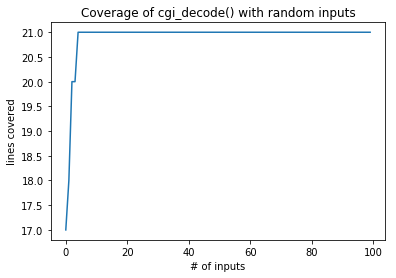

In [61]:
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

This is just _one_ run, of course; so let's repeat this a number of times and plot the averages.

In [ ]:
runs = 100

# Create an array with TRIALS elements, all zero
sum_coverage = [0] * trials

for run in range(runs):
    coverage = population_coverage(hundred_inputs(), cgi_decode)
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]

average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

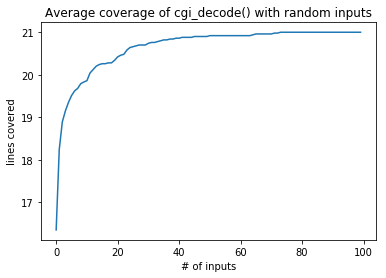

In [62]:
plt.plot(average_coverage)
plt.title('Average coverage of cgi_decode() with random inputs');
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

We see that on average, we get full coverage after 40–60 fuzzing inputs.

## Finding Errors with Basic Fuzzing

Given sufficient time, we can indeed cover each and every line within `cgi_decode()`.  This does not mean that they would be error-free, though.  Since we do not check the result of `cgi_decode()`, the function could return any value without us checking or noticing.  To catch such errors, we would have to set up a _results checker_ (commonly called an _oracle_) that would verify test results.  In our case, we could compare against another implementation of `cgi_decode()` and see whether both produce the same results.

Where fuzzing is great at, though, is in finding _internal errors_ that can be detected even without checking the result.  Actually, if one runs our `fuzzer()` on `cgi_decode()`, one quickly finds such an error, as the following code shows:

In [63]:
from ExpectError import ExpectError

with ExpectError():
    for i in range(TRIALS):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

Traceback (most recent call last):
  File "<ipython-input-63-ca5122f85035>", line 7, in <module>
    cgi_decode(s)
  File "<ipython-input-32-46709804f7f9>", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
IndexError: string index out of range


So, it is possible to cause `cgi_decode()` to crash.  Why is that?  Let's take a look at its input:

In [66]:
s

'/:*($62-?)?"464?1\'-!>)$;1++)01:9*/5# , 0.;:*,",\'.= !66.&%4'

The problem here is at the end of the string.  After a `'%'` character, our implementation will always attempt to access two more (hexadecimal) characters, but if these are not there, we will get an `IndexError` exception.  

This problem is actually also present in the original implementation \cite{Pezze2008}, where the code to access the next two characters reads

```c
int digit_high = Hex_values[*(++eptr)];
int digit_low  = Hex_values[*(++eptr)];
```

Here, `eptr` is a pointer to the character to be read; `++` increments it by one character.
In this C implementation, the problem is actually much worse.  If the `'%'` character is at the end of the string, the above code will first read a terminating character (`'\0'` in C strings) and then the following character, which may be any memory content after the string, and which thus may cause the program to fail uncontrollably.  The somewhat good news is that `'\0'` is not a valid hexadecimal character, and thus, the C version will "only" read one character beyond the end of the string.

Interestingly enough, none of the manual tests we had designed earlier would catch this bug.  Actually, neither statement nor branch coverage, nor any of the coverage criteria commonly discussed in literature would find it.  However, a simple fuzzing run can identify the error with a few runs.  This definitely calls for more fuzzing!

## Lessons Learned

* Coverage metrics are a simple and fully automated means to approximate how much functionality of a program is actually executed during a test run.
* A number of coverage metrics exist, the most important ones being statement coverage and branch coverage.
* In Python, it is very easy to access the program state during execution, including the currently executed code.

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](Mutation_Fuzzing.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

### Exercise 1

Create an appropriate test to reproduce the `IndexError` discussed above.  Fix `cgi_decode()` to prevent the bug.  Show that your test (and additional `fuzzer()` runs) no longer expose the bug.

_Solution for the exercise_

### Exercise 2

Besides statement coverage, _branch coverage_ is one of the most frequently used criteria to determine the quality of a test.  In a nutshell, branch coverage measures how many different _control decisions_ are made in code.  In the statement

```python
if CONDITION:
    do_a()
else:
    do_b()
```

for instance, both the cases where `CONDITION` is true (branching to `do_a()`) and where `CONDITION` is false (branching to `do_b()`) have to be covered.  This holds for all control statements with a condition (`if`, `while`, etc.).

How is branch coverage different from statement coverage?  In the above example, there is actually no difference.  In this one, though, there is:

```python
if CONDITION:
    do_a()
something_else()
```

Using statement coverage, a single test case where `CONDITION` is true suffices to cover the call to `do_a()`.  Using branch coverage, however, we would also have to create a test case where `do_a()` is _not_ invoked.

Using our `Coverage` infrastructure, we can simulate branch coverage by considering  _pairs of subsequent lines executed_.  The `trace()` method gives us the list of lines executed one after the other:

In [65]:
with Coverage() as cov:
    cgi_decode("a+b")
trace = cov.trace()
trace

[('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 32),
 ('__exit__', 25)]

Define a function `branch_coverage()` that takes a trace and returns the set of pairs of subsequent lines in a trace – in the above example, this would be 

```python
set(
(('cgi_decode', 9), ('cgi_decode', 10)),
(('cgi_decode', 10), ('cgi_decode', 11)),
# more_pairs
)
```

Use `branch_coverage()` to repeat the experiments in this chapter with branch coverage rather than statement coverage.  In particular:
* Do the manually written test cases cover all branches?  
* Does `fuzzer()` cover all branches, and if so, how long does it take on average?

Bonus for advanced Python programmers: Define `BranchCoverage` as subclass of `Coverage` and make `branch_coverage()` a method of `BranchCoverage`.

_Solution for the exercise_